# 18460 Project

In [1]:
%load_ext autoreload
%autoreload 2

from tasks import *
import numpy as np
from server import Server

First, we initialize the task for a given configuration

In [2]:
#task = lrt.LinearRegressionTask(lrt.solo_config) # Linear regression
#task = ct.CircleTask(ct.solo_config) # Circle
task = lgrt.LogisticRegressionTask() # Logistic regression with mushrooms

Intializing task LogisticRegressionTask with config Config(clients=4, number=200, lr=0.01)


Seeing the data

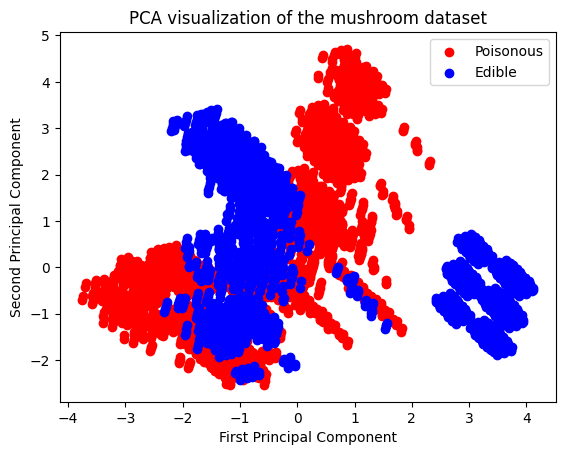

In [3]:
task.visualize()

Then, we define our optimization problem

In [4]:
problem = task.get_problem()
partitions = task.get_partitions()

Solve iteratively using federated learning

In [5]:
# Create server and initialize clients, before iteratively updating the consensus variables
server = Server(problem)
server.connect_clients(partitions) # add parameters and communicate datasets

k = 0
last_cost = float('infinity')
while k < problem.max_iter and server.delta > problem.tol:
    consensus = server.consensus.flatten()
    
    current_cost = problem.loss(consensus, task.dataset, problem.hyper_parameters)
    
    if k % 500 == 0:
        print(f'''
        Iteration {k}: {consensus}
        Cost: {current_cost}

        ''')
    
    # perform new iteration
    server.run_iteration(k+1)
    
    if np.linalg.norm(current_cost - last_cost) < problem.ctol:
        print(f"Condition reached: change in cost is {np.linalg.norm(current_cost - last_cost)} "
              f"which is smaller than {problem.ctol}")
        last_cost = current_cost
        break
        
    last_cost = current_cost
    
    k = k + 1
    
solution = server.consensus.flatten()

if k >= problem.max_iter and server.delta > problem.tol:
    raise Exception("Did not converge")
    
if server.delta <= problem.tol:
    print(f"Condition reached: change in solution is {server.delta} "
          f"which is smaller than {problem.tol}")

print("")
print(f"Solution: {solution}")
print(f"Associated cost: {last_cost}")
print(f"Achieved in {k} iterations")


        Iteration 0: [-1.89234873  0.67754862 -0.94710037 -0.17187471  0.188219    0.54245536
 -0.36966394 -0.64078699  0.34694452  0.14452109  0.98753791 -0.05402377
 -0.66169398 -1.25390335  1.07256675  2.75500208 -0.97161814 -0.94139735
 -0.04931743  0.45247278 -0.16621367 -1.04661762 -0.01795276]
        Cost: 13484.743880254318

        

        Iteration 500: [-0.04330016  0.24501123 -0.02009366 -1.22052006 -1.15218954 -0.6987769
 -1.63585122  2.52184491 -0.40633372  0.15796842 -0.68283089 -1.24671102
 -0.28101613  0.09262661  0.09467276  2.75500208  1.90044882  0.64434057
  0.06987202 -1.3343334  -0.13842824  0.18868354  0.09411822]
        Cost: 1675.9703627454614

        

        Iteration 1000: [-0.02716495  0.52149397  0.01066513 -1.4186946  -1.57401072 -1.27549726
 -2.19675002  3.48086982 -0.49371513  0.29817095 -0.73884804 -1.94563728
 -0.30050571 -0.07347516 -0.01780231  2.75500208  2.86948825  0.92174194
  0.64507436 -0.7797466  -0.63255181  0.15678615 -0.40606641]
 

## Visualization of the solution

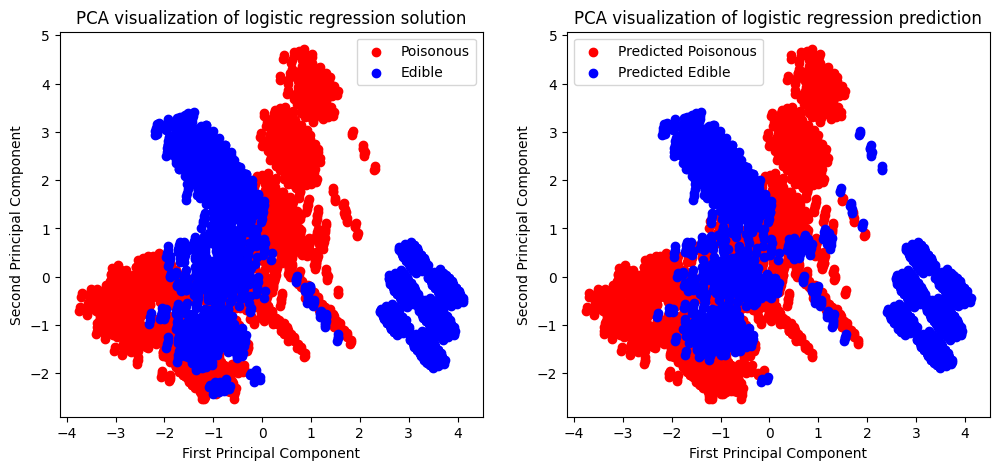

In [6]:
task.visualize_solution(solution)